# HW 3 - Regularization, Tree-based methods, Ensemble Learning

Complete the following questions and resubmit this entire notebook to canvas.
- For questions that ask you to derive or find a quantity use a __text cell__ to show your calculations.
 - Use markdown to write math expressions (as was done to create these problems) and make sure to show your work.
 - It doesnt have to be perfect looking but it needs to be readible.
 - You may also submit a legible picture of your derivation
- For questions that ask you compute something or write code use a __code cell__ to write your code.
 - You can create additional code cells as needed.
 - Just make sure your code is commented, the functions are named appropriately, and its easy to see your final answer.
- The total points on this homework is 100. Out of these 5 points are reserved for clarity of presentation,
punctuation and commenting with respect to the code.

__SUBMISSION__

When you submit you will submit a pdf file __and__ the notebook file. The TA will use the pdf file to grade more quickly. The notebook file is there to confirm your work.

To generate a pdf file
1. Click File
2. Click print
3. Set the destinationas "save as pdf"
4. Hit print

Title the pdf file `LASTNAME-FIRSTNAME-HW3.pdf`
Title your notebook file as `LASTNAME-FIRSTNAME-HW3.ipynb`

Submit both files.



In [1]:
# libraries and functions you may find useful
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange

## Q1 - Curse of Dimensionality (15 points)

### Part 1: Visualization (8 points)
1. For each of the specified dimensions \( p = 2, 10, 100, 1000 \), draw a sample of size \( n = 100 \) from a uniform distribution on the interval [0, 1] for each dimension. This can be done using the `np.random.uniform` function in Python.
2.For each sample, compute the Euclidean distance between every pair of points $ (x_i, x_j) $ where $ i < j $. Use the following formula for Euclidean distance between two points $ x_i $ and $ x_j $ in a p-dimensional space:
   $$
   ||x_i - x_j||_2 = \sqrt{\sum_{k=1}^p (x_{ik} - x_{jk})^2}
   $$
3. For each dimension $p$, create a histogram of the computed Euclidean distances. Each dimension's distances should be visualized in a separate histogram.

(4950,)
(4950,)
(4950,)
(4950,)


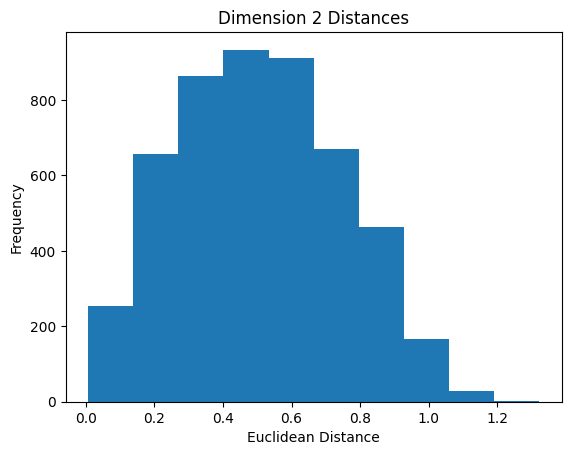

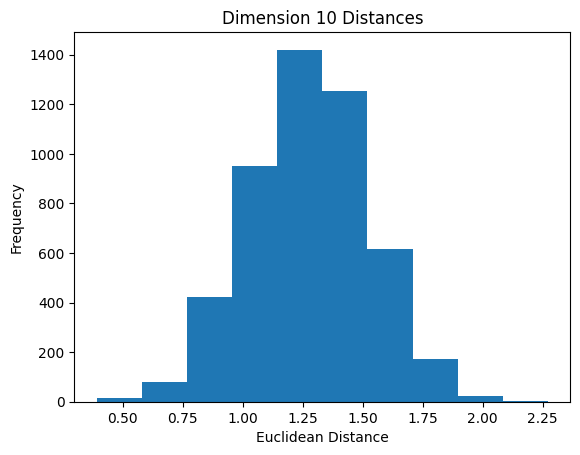

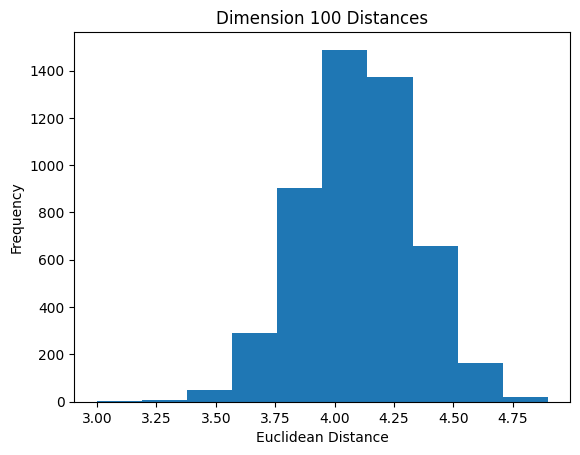

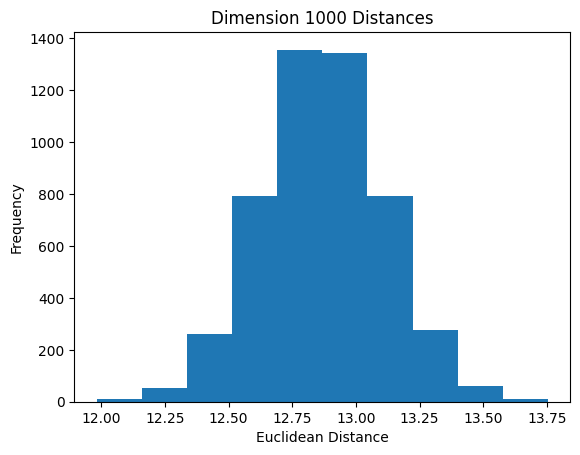

In [2]:
dimensions = [2 ,10, 100, 1000]
for dim in dimensions:
  sample = np.random.uniform(0,1, (100, dim))
  distances = []
  for i in range(100):
    for j in range(i+1, 100):
      diff = sample[i] - sample[j]
      dist = np.sqrt(np.sum(diff **2))
      distances.append(dist)
  distances = np.array(distances)
  print(distances.shape)
  plt.figure()
  plt.hist(distances)
  plt.xlabel("Euclidean Distance")
  plt.ylabel("Frequency")
  plt.title(f"Dimension {dim} Distances")
plt.show()

### Part 2: Discussion (7 points)
1. How does the distribution of distances change as the dimensionality increases? What do these changes suggest about the spacing of points in high-dimensional spaces?
2. Based on your observations, discuss the potential challenges and effectiveness of local prediction methods like KNN in high-dimensional spaces.

### Part 2: Answers

1. As dimensionality increases, the distances between points become larger. However, while the absolute differences increase, the spread of these distances relative to their means shrink. In high-dimensional spaces, closeness becomes less distinct, making it harder to distinguish between what is 'near' and 'far'. This means we must choose a tradeoff of if we want points to be of similar mean or closer together.

1. Since the spread of distances is lower in higher dimensions, models like KNN would have a difficult time distingushing between 'close' and 'far' points. This could degrade the performance of KNN as it wouldn't be able to classify points. In high dimensional spaces, features may be irrelevant or contain noise. Since KNN relies on distance metric, irrelevant dimensions can make it harder to identify similar instances.


## Q2 - Regularization (25 points)



In the class, we have discussed Ridge and LASSO regression.
Later we will use a fake dataset to illustrate how penalization works. Please do not change the seed.

In [3]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange

np.random.seed(0)

# random features (100 observations, 400 features)
x = np.random.normal(0, 1, [200, 400])

# only 5 features are relevant (non-zero coefficient)
beta = np.concatenate([2 * np.ones(5), np.zeros(395)]).reshape(-1, 1)

# outcome variable
y = x @ beta + 0.1 * np.random.normal(0, 1, [200, 1])

x = torch.tensor(x)
y = torch.tensor(y)

### part 1 - Ridge (9 points)

A ridge penalty is defined as $\lambda \sum_{j = 1}^p \beta_j^2$. If we modify the mean square error (MSE) to have a ridge penalty then the full loss function is

$$\mathcal{L} = \frac{1}{n}\sum_{i = 1}^n (y_i - x_i\beta)^2 + \lambda \sum_{j = 1}^p \beta_j^2$$

where $\beta_j$ denotes the $j$th entry of $\beta$.

1. Define a new loss function `mse_ridge()` which computes the above loss for a given value of $\lambda$ (you choose $\lambda$). Hint: `lambda` is a reserved keyword in Python so use `lam` instead.

2. Using the above loss fit three models. One where $\lambda = 0$, one where $\lambda = 2$ and one where $\lambda = 10$. Plot the estimated $\beta$ vector for each model. Do you notice any systematic differences when changing $\lambda$ from a small to a large number?

3. Recall that the point of ridge penalization is encourage $\beta$ to be small. Why would setting $\lambda$ to a negative number actually encourage large $\beta$ values instead? Think about what happens when you minimize the loss.

In [4]:
beta = torch.tensor(beta)
def mse_ridge(model, x, y, lam):
  return  (1 / len(x)) * torch.sum((y - x @ model.beta)**2) + lam * torch.sum(model.beta**2)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

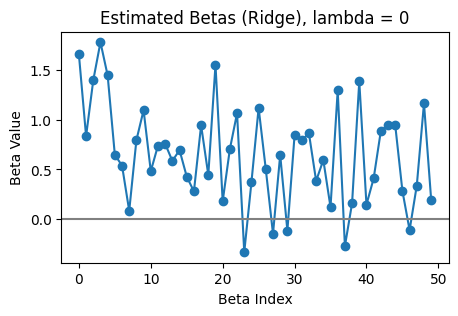

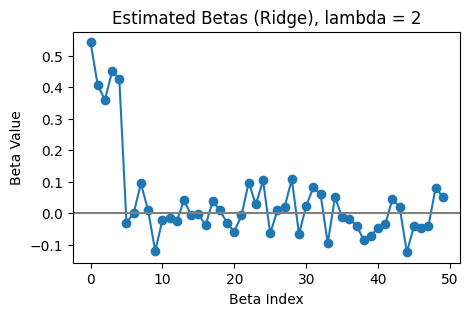

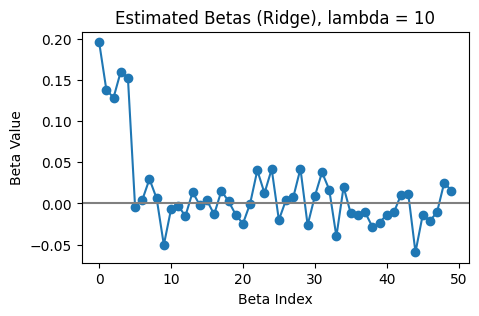

In [5]:
# plot betas
lambdas = [0, 2, 10]
class LinearRegression(nn.Module):
    def __init__(self, x, y):
      super(LinearRegression, self).__init__()
      self.beta = torch.ones(x.shape[1]).double().reshape(-1, 1)
      self.beta.requires_grad_()

    def forward(self, x):
      return x @ self.beta

lr1 = LinearRegression(x,y)

for lam in lambdas:
  for _ in trange(10000):
    loss = mse_ridge(lr1, x, y, lam)
    loss.backward()

    lr1.beta.data = lr1.beta.data - 1e-3 * lr1.beta.grad
    lr1.beta.grad.zero_()

  plt.figure(figsize = (5, 3))
  plt.plot(lr1.beta[0:50].detach(), marker = 'o', label = 'Ridge')
  plt.axhline(0,c = 'grey')
  plt.xlabel('Beta Index')
  plt.ylabel('Beta Value')
  plt.title(f'Estimated Betas (Ridge), lambda = {lam}')


### part 2 - LASSO (9 points)

A LASSO penalty is defined as $\lambda \sum_{j = 1}^p |\beta_j|$. If we modify the mean square error (MSE) to have a LASSO penalty then the full loss function is

$$\mathcal{L} = \frac{1}{n}\sum_{i = 1}^n (y_i - x_i\beta)^2 + \lambda \sum_{j = 1}^p |\beta_j|$$

where $\beta_j$ denotes the $j$th entry of $\beta$.

1. Define a new loss function `mse_lasso()` which computes the above loss for a given value of $\lambda$ (you choose $\lambda$).

2. Using the above loss fit three models. One where $\lambda = 0$, one where $\lambda = 2$ and one where $\lambda = 10$. Plot the estimated $\beta$ vector for each model. Do you notice any systematic differences when changing $\lambda$ from a small to a large number?


In [6]:
# write some code here
def mse_lasso(model, x, y, lam):
  return (1/(len(x))) * torch.sum((y - x @ model.beta)**2) + lam * torch.sum(torch.abs(model.beta))

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

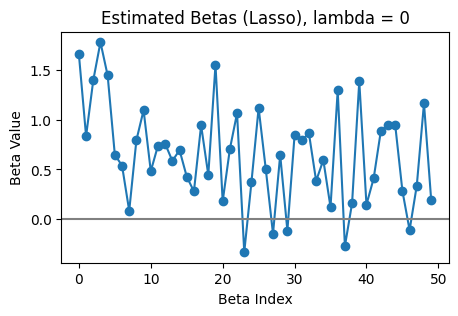

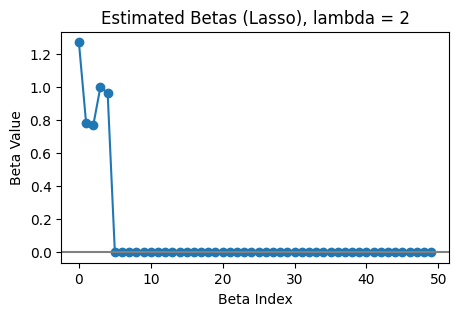

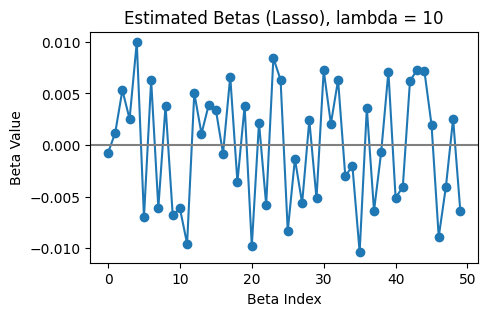

In [7]:
# plot betas
lr2 = LinearRegression(x,y)

for lam in lambdas:
  for _ in trange(10000):
    loss = mse_lasso(lr2, x, y, lam)
    loss.backward()

    lr2.beta.data = lr2.beta.data - 1e-3 * lr2.beta.grad
    lr2.beta.grad.zero_()

  plt.figure(figsize = (5, 3))
  plt.plot(lr2.beta[0:50].detach(), marker = 'o', label = 'Lasso')
  plt.axhline(0,c = 'grey')
  plt.xlabel('Beta Index')
  plt.ylabel('Beta Value')
  plt.title(f'Estimated Betas (Lasso), lambda = {lam}')

### part 3 - Compare (7 points)

Compute the test MSE for each of the 6 models (3 ridge models and 3 LASSO models). Which model performed the best?

In [8]:
### Simulate testing dataset
np.random.seed(1)

# only 5 features are relevant (non-zero coefficient)
beta = np.concatenate([2 * np.ones(5), np.zeros(395)]).reshape(-1, 1)

## resimulate a test dataset
x_test = x
y_test = x @ beta + 0.1 * np.random.normal(0, 1, [200, 1])

<ipython-input-8-a33d10b11233>:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_test = x @ beta + 0.1 * np.random.normal(0, 1, [200, 1])


In [9]:
def mse_loss(model, x, y):
  return torch.mean((y-model(x))**2)

lr3 = LinearRegression(x_test,y_test)

for lam in lambdas:
  for _ in trange(10000):
    loss = mse_ridge(lr3, x_test, y_test, lam)
    loss.backward()

    lr3.beta.data = lr3.beta.data - 1e-3 * lr3.beta.grad
    lr3.beta.grad.zero_()

  print(f'MSE loss (RIDGE), lambda = {lam}')
  print(mse_loss(lr3, x_test, y_test))

lr4 = LinearRegression(x_test,y_test)

for lam in lambdas:
  for _ in trange(10000):
    loss = mse_lasso(lr4, x_test, y_test, lam)
    loss.backward()

    lr4.beta.data = lr4.beta.data - 1e-3 * lr4.beta.grad
    lr4.beta.grad.zero_()

  print(f'MSE loss (LASSO), lambda = {lam}')
  print(mse_loss(lr4, x_test, y_test))


  0%|          | 0/10000 [00:00<?, ?it/s]

MSE loss (RIDGE), lambda = 0
tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)


  0%|          | 0/10000 [00:00<?, ?it/s]

MSE loss (RIDGE), lambda = 2
tensor(4.2592, dtype=torch.float64, grad_fn=<MeanBackward0>)


  0%|          | 0/10000 [00:00<?, ?it/s]

MSE loss (RIDGE), lambda = 10
tensor(12.2948, dtype=torch.float64, grad_fn=<MeanBackward0>)


  0%|          | 0/10000 [00:00<?, ?it/s]

MSE loss (LASSO), lambda = 0
tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)


  0%|          | 0/10000 [00:00<?, ?it/s]

MSE loss (LASSO), lambda = 2
tensor(5.1779, dtype=torch.float64, grad_fn=<MeanBackward0>)


  0%|          | 0/10000 [00:00<?, ?it/s]

MSE loss (LASSO), lambda = 10
tensor(19.6464, dtype=torch.float64, grad_fn=<MeanBackward0>)


The best performing model was either RIDGE with lambda = 0 or LASSO with lambda = 0. They were both equal, but that was expected since we would be eliminating the penalty.

## Q3 - Multi-target Classification with Regularization (30 points)

We will use a "rectangles" dataset to test out our method. Your task is simple. Given an image classify whether it contains a blue rectangle, a red rectangle, a green rectangle, or no rectangle. We will generate this dataset below so please do not change the seeds.


### Recall: multi-target logistic regression

A multi-target logistic regression when we have $k$ categories is defined as
\begin{align}
y_i &\sim Categorical((p_1,...,p_k)_i) \\
(p_1,...,p_k)_i &= \sigma(x_i\beta + \alpha)
\end{align}

How to read this:
1. Take a $p$ dimensional input vector $x_i$ and multiple it by the __matrix__ $\beta_{p \times k}$ then add the vector $\alpha_{1\times k}$ to get a $k$ dimensional vector of log probabilties

2. Squash the log probabilities $z_i = x_i\beta + \alpha$ to all be between 0 and 1, and sum to 1, by applying the __softmax function__ $\sigma(\cdot)$. The $j$'th entry $(j = 1,...,k)$ of $\sigma(z_i)$ is equal to
$$
\sigma(z_i)_j = \frac{\exp((z_i)_j)}{\sum_{j = 1}^k\exp((z_i )_j)}
$$
where $((z_i)_j)$ means the  $j$'th entry of $z_i$.

3. We say $y_i$ belongs to class $j$ with probability $\sigma(z_i)_j$

Also recall:
We represent $Y_{n\times1}$ as a $Y_{n\times k}$ one-hot encoded matrix so that we can derive the __multi-target CE loss__ function from the categorical distribution as

\begin{align}
\mathcal{L}(\beta) &= -\frac{1}{nk}\sum_{i=1}^n \sum_{j=1}^k y_{i,j} \log(\sigma(x_i \beta))_j \\
\end{align}

In [10]:
!pip install scikit-image --upgrade

from tqdm.notebook import trange
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from skimage.draw import random_shapes
from skimage.util import random_noise

Generate the rectangle data below

In [11]:
m1, m2, m3, m4 = 200, 200, 200, 200
n = m1 + m2 + m3 + m4

rng = 0

## generate blues
blue_imgs = []
for _ in trange(m1):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((20, 20),(20,20),(255,255)),
                         rng = rng
                         )

  img = random_noise(img, mode='speckle', var = 0.03, rng = rng)
  blue_imgs.append(img)
  rng += 1

blue_imgs = np.array(blue_imgs)
blue_labs = 0*np.ones(m1)

## generate reds
red_imgs = []
for _ in trange(m2):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((255,255),(20, 20),(20,20)),
                         rng = rng)

  img = random_noise(img, mode='speckle', var = 0.03, rng = rng)
  red_imgs.append(img)
  rng += 1

red_imgs = np.array(red_imgs)
red_labs = 1*np.ones(m2)

## generate greens
green_imgs = []
for _ in trange(m3):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((20, 20),(255,255),(20,20)),
                         rng = rng)

  img = random_noise(img, mode='speckle', var = 0.03, rng = rng)
  green_imgs.append(img)
  rng += 1

green_imgs = np.array(green_imgs)
green_labs = 2*np.ones(m3)

## generate blanks
none_imgs = []
for _ in trange(m4):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((255, 255),(255,255),(255,255)),
                         rng = rng)

  img = random_noise(img, mode='speckle', var = 0.03, rng = rng)
  none_imgs.append(img)
  rng += 1

none_imgs = np.array(none_imgs)
none_labs = 3*np.ones(m4)

imgs = np.vstack([blue_imgs, red_imgs, green_imgs, none_imgs])
labs = np.concatenate([blue_labs, red_labs, green_labs, none_labs]).astype(np.int64)
np.random.seed(0)
idx = np.random.permutation(np.arange(n))
imgs = imgs[idx]
labs = labs[idx]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

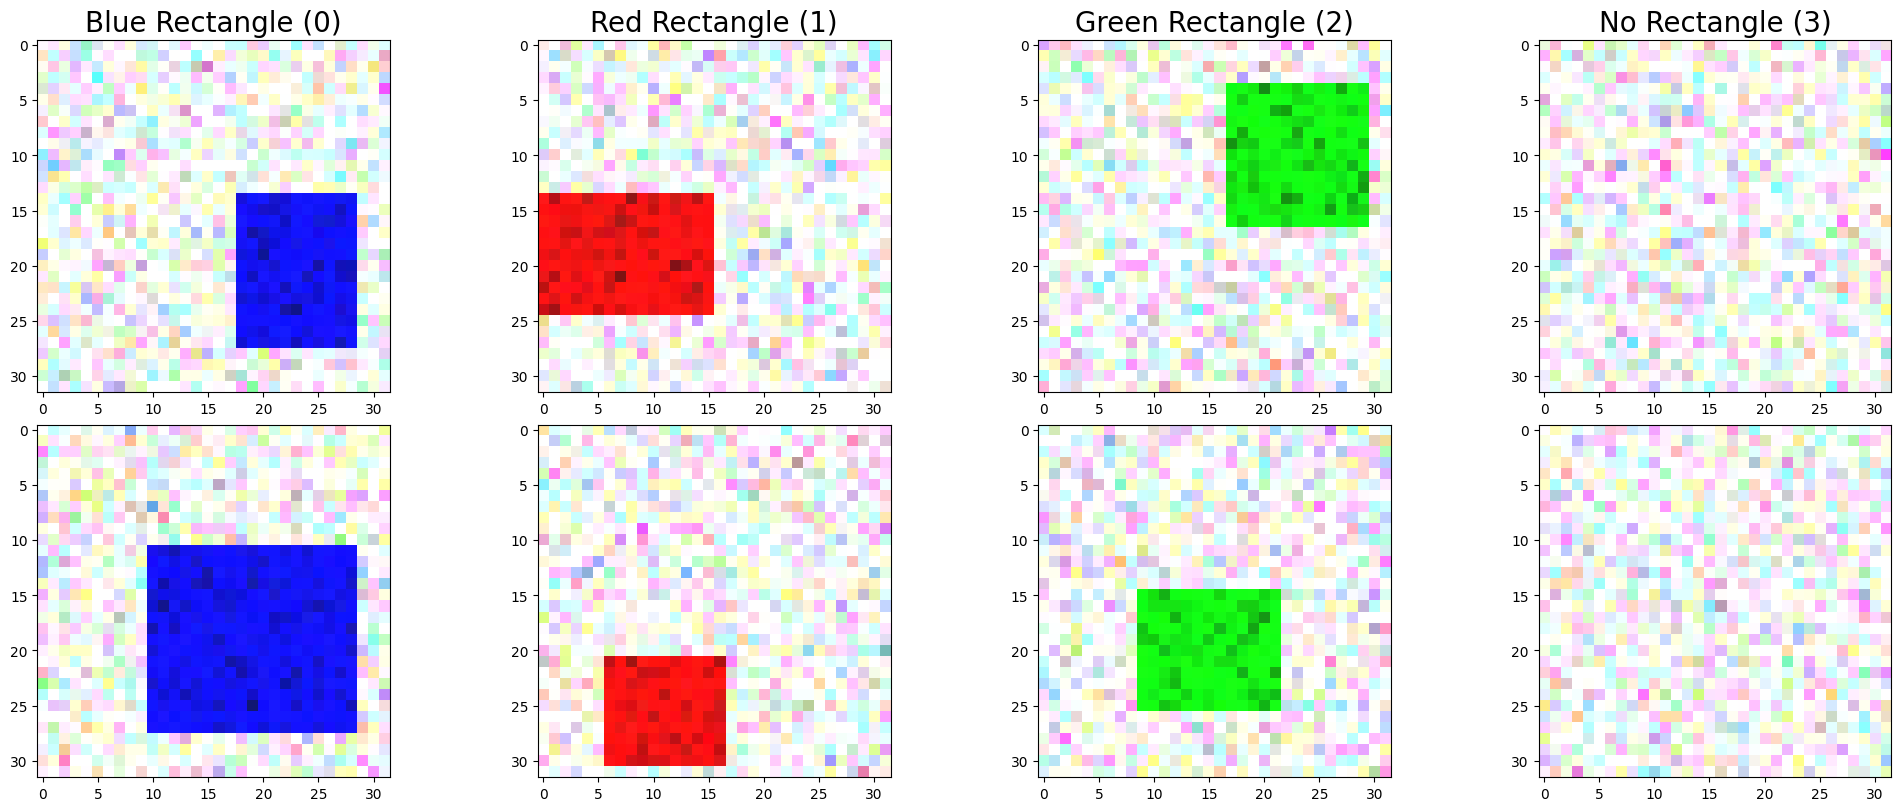

In [12]:
fig, ax = plt.subplots(2, 4, constrained_layout = True, figsize = (20, 8))
ax[0,0].imshow(blue_imgs[0])
ax[0,1].imshow(red_imgs[0])
ax[0,2].imshow(green_imgs[0])
ax[0,3].imshow(none_imgs[0])

ax[1,0].imshow(blue_imgs[1])
ax[1,1].imshow(red_imgs[1])
ax[1,2].imshow(green_imgs[1])
ax[1,3].imshow(none_imgs[1])

ax[0,0].set_title('Blue Rectangle (0)', fontsize = 20)
ax[0,1].set_title('Red Rectangle (1)', fontsize = 20)
ax[0,2].set_title('Green Rectangle (2)', fontsize = 20)
ax[0,3].set_title('No Rectangle (3)', fontsize = 20)
plt.show()

The above plots show an example of each class. We code blue as 0, red as 1, green as 2, and none as 3. Each image contains a fair amount of degredation and rectangles are randomly generated somewhere in the image with a random size.

In [13]:
from torch.nn.functional import one_hot
from sklearn.model_selection import train_test_split

x = torch.tensor(imgs).reshape(n, -1)
y = one_hot(torch.tensor(labs))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

### part 1 - Implement the model (8 points)

Let's use our `MultiLogisticRegression` class you previously created from homework 2. This class should do the following

1. Automatically determine the shapes of $\beta$ and $\alpha$ from the data `x` and `y`
2. Initialize $\alpha$ and $\beta$ at 0 and enable gradient tracking
3. Include a `forward()` function that computes class probabilities given input `x`
4. Include a `classify()` function that classifies inputs `x`, i.e. return the class with the highest probability.


To make sure its working. Instantiate your class and call the forward function on `x_train`. Print the output (it should be a tensor of all $0.25$)


In [14]:
## numerical minimization
import torch
import torch.nn as nn

class MultiLogisticRegression(nn.Module):
    def __init__(self, x, y):
      super(MultiLogisticRegression, self).__init__()
      self.beta = torch.zeros(x.shape[1], y.shape[1]).double()
      self.alpha = torch.zeros(1, y.shape[1]).double()
      self.beta.requires_grad_()
      self.alpha.requires_grad_()

    def forward(self, x):
      t = x @ self.beta + self.alpha
      return torch.softmax(t, axis = 1)

    def classify(self, x):
      p = self.forward(x)
      return torch.argmax(p, axis = 1)

In [15]:
mlr = MultiLogisticRegression(x_train, y_train)
mlr.forward(x_train)

tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        ...,
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)

### Part 2 - Training (15 points)

1. Train three multi-target logisitic regression models on the rectangles dataset to classify images of rectangles. Use the model above and write your own loss functions. Write your own gradient descent loop. Fit the three models by training with
  1. cross entropy
  2. cross entropy with a ridge penalty
  3. cross entropy with a LASSO penalty

2. Plot the loss trace (did it converge?) for each model and print the test __accuracy__ and __cross entropy__ for each model. The test accuracy needs to be above $0.97$ for at least one of these models. State which model performed the best on test in terms of cross entropy or accuracy.

3. Extra 5 points if you achieve a test accuracy over $0.994$ (its possible)

_hint 1: Try 1000-3000 training iterations with a learning rate between 1e-2 and 1e-3_

_hint 2: Consider using a mean rather than a sum in your ridge/lasso penalties to automatically scale the penalty by the sample size_

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 0: Cross Entropy = 0.34657359027997264
Epoch 600: Cross Entropy = 0.05246422631480112
Epoch 1200: Cross Entropy = 0.02940389618392649
Epoch 1800: Cross Entropy = 0.020352341819039506
Epoch 2400: Cross Entropy = 0.015519701517500865


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 0: Cross Entropy (ridge) = 0.34657359027997264
Epoch 600: Cross Entropy (ridge) = 0.05273826588318234
Epoch 1200: Cross Entropy (ridge) = 0.029858691771175273
Epoch 1800: Cross Entropy (ridge) = 0.02094156068091802
Epoch 2400: Cross Entropy (ridge) = 0.016217077831674566


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 0: Cross Entropy (lasso) = 0.34657359027997264
Epoch 600: Cross Entropy (lasso) = 0.07297618941087722
Epoch 1200: Cross Entropy (lasso) = 0.0547701954980785
Epoch 1800: Cross Entropy (lasso) = 0.04839048002435724
Epoch 2400: Cross Entropy (lasso) = 0.045276882967541135

Cross Entropy Accuracy:  0.9810606060606061
Cross Entropy + Ridge Accuracy:  0.9810606060606061
Cross Entropy + Lasso Accuracy:  0.9810606060606061


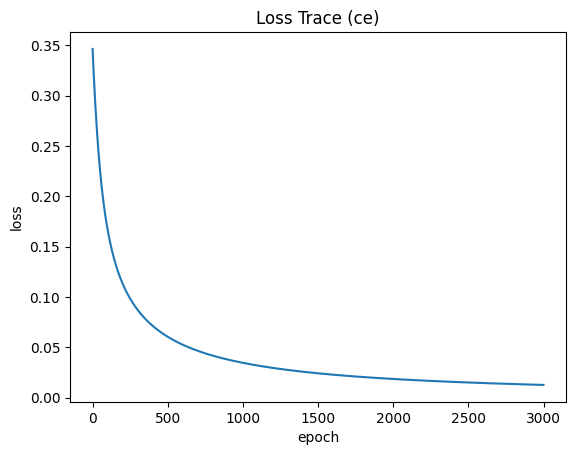

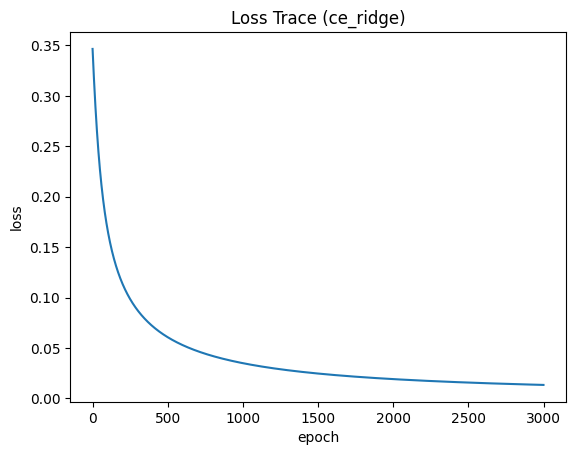

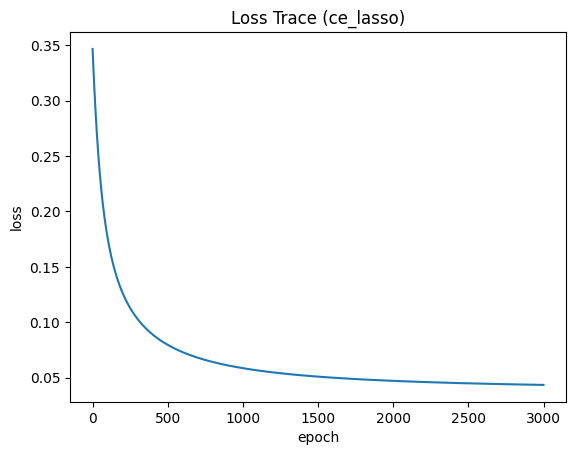

In [16]:
def cross_entropy_loss(model,x ,y):
  y_pred = model.forward(x)
  n, k = y.shape
  return -torch.sum(y * torch.log(y_pred)) / (n * k)

def cross_entropy_ridge(model, x, y, lambda_ridge=2):
  ce_loss = cross_entropy_loss(model,x,y)
  ridge_penalty = lambda_ridge * torch.mean(model.beta ** 2)
  return ce_loss + ridge_penalty

def cross_entropy_lasso(model, x, y, lambda_lasso=2):
  ce_loss = cross_entropy_loss(model,x,y)
  lasso_penalty = lambda_lasso * torch.mean(torch.abs(model.beta))
  return ce_loss + lasso_penalty


mlr_ce = MultiLogisticRegression(x_train, y_train)
mlr_ce_ridge = MultiLogisticRegression(x_train, y_train)
mlr_ce_lasso = MultiLogisticRegression(x_train, y_train)

n_epoch = 3000
loss_trace_ce = np.zeros(n_epoch)
loss_trace_ce_ridge = np.zeros(n_epoch)
loss_trace_ce_lasso = np.zeros(n_epoch)


# cross entropy
for i in trange(n_epoch):
  loss_ce = cross_entropy_loss(mlr_ce, x_train, y_train)
  loss_trace_ce[i] = loss_ce
  loss_ce.backward()

  mlr_ce.beta.data = mlr_ce.beta.data - 1e-2 * mlr_ce.beta.grad
  mlr_ce.alpha.data = mlr_ce.alpha.data - 1e-2 * mlr_ce.alpha.grad
  mlr_ce.beta.grad.zero_()
  mlr_ce.alpha.grad.zero_()

  if i % 600 == 0:
    print(f"Epoch {i}: Cross Entropy = {loss_ce.item()}")
plt.figure()
plt.plot(loss_trace_ce)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss Trace (ce)")


# cross entropy + ridge
for i in trange(n_epoch):
  loss_ce_ridge = cross_entropy_ridge(mlr_ce_ridge, x_train, y_train)
  loss_trace_ce_ridge[i] = loss_ce_ridge
  loss_ce_ridge.backward()

  mlr_ce_ridge.beta.data = mlr_ce_ridge.beta.data - 1e-2 * mlr_ce_ridge.beta.grad
  mlr_ce_ridge.alpha.data = mlr_ce_ridge.alpha.data - 1e-2 * mlr_ce_ridge.alpha.grad
  mlr_ce_ridge.beta.grad.zero_()
  mlr_ce_ridge.alpha.grad.zero_()
  if i % 600 == 0:
    print(f"Epoch {i}: Cross Entropy (ridge) = {loss_ce_ridge.item()}")
plt.figure()
plt.plot(loss_trace_ce_ridge)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss Trace (ce_ridge)")


#cross entropy + lasso
for i in trange(n_epoch):
  loss_ce_lasso = cross_entropy_lasso(mlr_ce_lasso, x_train, y_train)
  loss_trace_ce_lasso[i] = loss_ce_lasso
  loss_ce_lasso.backward()

  mlr_ce_lasso.beta.data = mlr_ce_lasso.beta.data - 1e-2 * mlr_ce_lasso.beta.grad
  mlr_ce_lasso.alpha.data = mlr_ce_lasso.alpha.data - 1e-2 * mlr_ce_lasso.alpha.grad
  mlr_ce_lasso.beta.grad.zero_()
  mlr_ce_lasso.alpha.grad.zero_()
  if i % 600 == 0:
    print(f"Epoch {i}: Cross Entropy (lasso) = {loss_ce_lasso.item()}")
plt.figure()
plt.plot(loss_trace_ce_lasso)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss Trace (ce_lasso)")

yhat_ce = mlr_ce.classify(x_test).numpy()
yhat_ce_ridge = mlr_ce_ridge.classify(x_test).numpy()
yhat_ce_lasso = mlr_ce_lasso.classify(x_test).numpy()

ytest = torch.argmax(y_test, axis = 1).numpy()
print()
print("Cross Entropy Accuracy: " ,np.mean(yhat_ce == ytest))
print("Cross Entropy + Ridge Accuracy: ",np.mean(yhat_ce_ridge == ytest))
print("Cross Entropy + Lasso Accuracy: ",np.mean(yhat_ce_lasso == ytest))

Since all accuracies were the same, the model that performed the best was cross entropy without any penalty as it achieved the lowest cross-entropy.

### Part 3 - Evaluate (7 points)

1. Check the classification report for whichever model performed the best. Are there any colors (classes) that your model performed particularly poorly on? How might you improve your model on specific classes?

In [17]:
from sklearn.metrics import classification_report
print("Classification report for cross entropy model:")
print(classification_report(ytest, yhat_ce))

Classification report for cross entropy model:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        67
           1       1.00      0.98      0.99        63
           2       1.00      0.99      0.99        68
           3       0.93      1.00      0.96        66

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264



Class 3's precision is still high, but it is still lower than the other classes and the f-1 score is the lowest at 0.96. This model is still likely to predict class 3 correctly. One way to address class 3's precision is to check for imbalanced data or using class weights

## Q4 Tree-based Method and Ensembling (25 points)

In this problem our goal is to estimate the popularity of online articles published over the last years. The provided data contain articles published by Mashable in a period of two years. The goal is to predict the number of shares in social networks, which approximates the popularity of an article.

We will use the dataset from UCI machine learning database:
https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity#


In [18]:
!pip install ucimlrepo

In [19]:
### download the dataset
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_news_popularity = fetch_ucirepo(id=332)

In [20]:
# data (as pandas dataframes)
x = online_news_popularity.data.features
y = online_news_popularity.data.targets

# metadata
print(online_news_popularity.metadata)

{'uci_id': 332, 'name': 'Online News Popularity', 'repository_url': 'https://archive.ics.uci.edu/dataset/332/online+news+popularity', 'data_url': 'https://archive.ics.uci.edu/static/public/332/data.csv', 'abstract': 'This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years. The goal is to predict the number of shares in social networks (popularity).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 39797, 'num_features': 58, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': [' shares'], 'index_col': ['url'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Thu Feb 15 2024', 'dataset_doi': '10.24432/C5NS3V', 'creators': ['Kelwin Fernandes', 'Pedro Vinagre', 'Paulo Cortez', 'Pedro Sernadela'], 'intro_paper': {'ID': 390, 'type': 'NATIVE', 'title': 'A Proactive Intelligent Decisio

In [21]:
# variable information
x.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,...,0.353825,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064
std,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,...,0.104542,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,...,0.306244,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664082,...,0.358755,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000
75%,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,...,0.411428,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,8.041534,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


In [22]:
y.describe()

,shares
count,39644.000000
mean,3395.380184
std,11626.950749
min,1.000000
25%,946.000000
50%,1400.000000
75%,2800.000000
max,843300.000000


In [23]:
## scale the target
y = np.log(y+1)
y.describe()

,shares
count,39644.000000
mean,7.475692
std,0.929674
min,0.693147
25%,6.853299
50%,7.244942
75%,7.937732
max,13.645079


In [24]:
# train, test, val
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

### scale inputs (optional for tree-based method)
x_mean = np.mean(xtrain, axis = 0)
x_sd = np.std(xtrain, axis = 0)

xtrain = (xtrain - x_mean) / x_sd
xtest = (xtest - x_mean) / x_sd

xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

In [25]:
ytrain = np.array(ytrain).reshape(-1, 1)
ytest = np.array(ytest).reshape(-1, 1)
yval = np.array(yval).reshape(-1, 1)

In [26]:
xtrain.shape

(25372, 58)

In [27]:
xtrain.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
19052,0.281576,-0.330111,0.004375,-0.000485,0.001385,1.157086,-0.077491,0.653367,-0.301914,0.322553,...,0.185052,0.072069,0.172098,-0.136021,0.076074,0.426530,1.183743,0.983073,-0.928867,0.777279
18023,0.752976,-0.399793,0.028412,-0.000485,0.045517,0.097684,-0.338939,-0.427951,-0.301914,0.113234,...,-1.559626,-0.458901,-1.540609,0.485643,0.420422,0.993259,0.361687,-1.766076,-1.282312,1.070557
16532,0.281576,3.445341,-0.054580,-0.000485,-0.052454,4.864993,3.059894,3.296587,-0.301914,0.125536,...,0.775566,-0.458901,0.978078,0.155794,-0.956971,0.600908,0.361687,-0.641425,-1.282312,-0.249193
38998,0.752976,-0.784095,0.030578,-0.000485,0.028822,-0.696868,-0.077491,-0.427951,-0.061705,0.020574,...,0.037579,0.072069,0.172098,-0.415508,0.721726,-2.145549,0.780055,0.804557,-1.623133,0.567795
23063,-1.132623,-0.881226,0.052704,-0.000485,0.042707,-0.343734,0.183958,-0.548097,0.178503,0.082371,...,0.131063,0.586949,-1.036872,0.466053,1.109118,-0.968496,-0.871396,-0.266541,0.838354,-0.689110


### Part 1 - Decision Tree Regression (9 points)
Estimate the number of shares of an article on the test data using a decision tree regressor `DecisionTreeRegressor`.

1. Train your regression tree with different depth of the decision tree (use `max_depth`). Please at least try three diffenrent depth. Then use the validation dataset to determine the optimal depth of the decision tree.
2. For your final model, report the MSE on your training, validation and test dataset.



In [28]:
from sklearn.tree import DecisionTreeRegressor
dtr1 = DecisionTreeRegressor(max_depth = 1)
dtr1.fit(xtrain, ytrain)

dtr5 = DecisionTreeRegressor(max_depth = 5)
dtr5.fit(xtrain, ytrain)

dtr10 = DecisionTreeRegressor(max_depth = 10)
dtr10.fit(xtrain, ytrain)


yhat1 = dtr1.predict(xval)
yhat5 = dtr5.predict(xval)
yhat10 = dtr10.predict(xval)

print("max_depth = 1 MSE: ",np.mean((yhat1 - np.array(yval)) **2))
print("max_depth = 5 MSE: ",np.mean((yhat5 - np.array(yval)) **2))
print("max_depth = 10 MSE: ",np.mean((yhat10 - np.array(yval)) **2))


max_depth = 1 MSE:  0.9025307628126285
max_depth = 5 MSE:  0.9650881672472941
max_depth = 10 MSE:  1.1204150992163724


Based on the MSE's the model with a max_depth of 1 was the most optimal model.

In [29]:
print("Optimal Tree Depth: 1")
print(f"Training MSE: {np.mean((dtr1.predict(xtrain)- np.array(ytrain))**2)}")
print(f"Validation MSE: {np.mean((dtr1.predict(xval)- np.array(yval))**2)}")
print(f"Test MSE: {np.mean((dtr1.predict(xtest)- np.array(ytest))**2)}")

Optimal Tree Depth: 1
Training MSE: 0.9111438400889458
Validation MSE: 0.9025307628126285
Test MSE: 0.9005735474642533


### Part 2 - Random Forest Regression (9 points)

Implement regression forest to estimate the number
of shares of an article on the test data using a random rofest regressor `RandomForestRegressor`.

1. Train your random forest with different settings for parameter `max_features` (use `max_features = "log2", 20, 1.0`). Keep other parameters as default `max_depth=None`. When you set `max_features = 1.0`, you use all features for splitting. Then use the validation dataset to determine the optimal parameter.
2. For your final model, report the MSE on your training, validation and test dataset.
3. Extra 5 points if you build your random forest from scratch, without using function `RandomForestRegressor`. You can use any library for decision tree, but you have to implement the random rofest algorithm (i.e., bootstrap the input samples and random subspace for each split for each tree, combine the results from all trees to obtain a final decision).


In [30]:
from sklearn.ensemble import RandomForestRegressor

ytrain = ytrain.ravel()

rflog = RandomForestRegressor(max_features = "log2", max_depth = None)
rflog.fit(xtrain, ytrain)
yhatlog = rflog.predict(xtrain)
print(f'max features: "log2" MSE: ', np.mean((yhatlog - ytrain)**2))

rf20 = RandomForestRegressor(max_features = 20, max_depth = None)
rf20.fit(xtrain, ytrain)
yhat20 = rf20.predict(xtrain)
print(f'max features: 20 MSE: ', np.mean((yhat20 - ytrain)**2))

rf1 = RandomForestRegressor(max_features = 1.0, max_depth = None)
rf1.fit(xtrain, ytrain)
yhat1 = rf1.predict(xtrain)
print(f'max features: 1.0 MSE: ', np.mean((yhat1 - ytrain)**2))


max features: "log2" MSE:  0.10254939854627176
max features: 20 MSE:  0.10327975807905618
max features: 1.0 MSE:  0.1035909021269623


The optimal parameter was the model with max_features = log2

In [31]:

print("Training MSE: ", np.mean( ( rflog.predict(xtrain) - ytrain) **2))
print("Validation MSE: ", np.mean( ( rflog.predict(xval) - yval) **2))
print("Test MSE: ", np.mean( ( rflog.predict(xtest) - ytest) **2))

Training MSE:  0.10254939854627176
Validation MSE:  0.9771381844855529
Test MSE:  0.979109702040982


### Part 3 - Feature importance (7 points)



1. Compute the feature importance scores from your final models from both Part 1 and Part 2.
2. Identify the most important features for predicting the popularity score. Please report these features and provide your intuitions.

In [32]:
importancelog = pd.DataFrame({"Variable": x.columns,
                           "RF log2 Importance": rflog.feature_importances_})

importance20 = pd.DataFrame({"Variable": x.columns,
                           "RF 20 Importance": rf20.feature_importances_})

importance1 = pd.DataFrame({"Variable": x.columns,
                           "RF 1.0 Importance": rf1.feature_importances_})

importancelog = importancelog.sort_values(by = "RF log2 Importance", ascending = False)
importance20 = importance20.sort_values(by = "RF 20 Importance", ascending = False)
importance1 = importance1.sort_values(by = "RF 1.0 Importance", ascending = False)

print(importancelog.head(10))
print()
print(importance20.head(10))
print()
print(importance1.head(10))

                       Variable  RF log2 Importance
25                   kw_avg_avg            0.046983
24                   kw_max_avg            0.042010
39                       LDA_02            0.031848
28   self_reference_avg_sharess            0.031137
26    self_reference_min_shares            0.029771
22                   kw_avg_max            0.028729
40                       LDA_03            0.028063
38                       LDA_01            0.027555
19                   kw_avg_min            0.027317
27    self_reference_max_shares            0.027172

                       Variable  RF 20 Importance
25                   kw_avg_avg          0.068782
24                   kw_max_avg          0.045552
28   self_reference_avg_sharess          0.035727
22                   kw_avg_max          0.030720
39                       LDA_02          0.030392
26    self_reference_min_shares          0.029513
38                       LDA_01          0.029378
41                       LD

After sorting the feature importances in descending value, I took the top 10 for each model and printed them out. We can see that there are similar features in each of the models. Namely: kw_avg_acg, kw_max_avg, self_reference_avg_sharess, LDA_03, kw_avg_max, LDA_01, and LDA_04. Since three of these models agree with these features having high importance values, it is likely that these features are significant in predicting the number of shares of an artic